In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 11.3 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout

from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket

import seaborn as sns

from glob import glob
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [5]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [6]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')

In [7]:
def get_duration(file):

    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    time = librosa.get_duration(y=audio, sr=sample_rate)

    return time

In [8]:
duration = []

for index_num, row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    time = get_duration(file_name)

    duration.append(time)

3480it [13:56,  4.16it/s]


In [9]:
df['duration'] = duration
sorted_df = df[df.duration <= 3]
sorted_df['class'].value_counts()

Grunt    1491
Roar      993
IRoar     987
Name: class, dtype: int64

In [10]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [11]:
appended = []
for i in range(1,4):
    appended.append(sorted_df[sorted_df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Grunt,Roar,IRoar
0,fold1,496,332,326
1,fold2,496,329,329
2,fold3,499,332,332


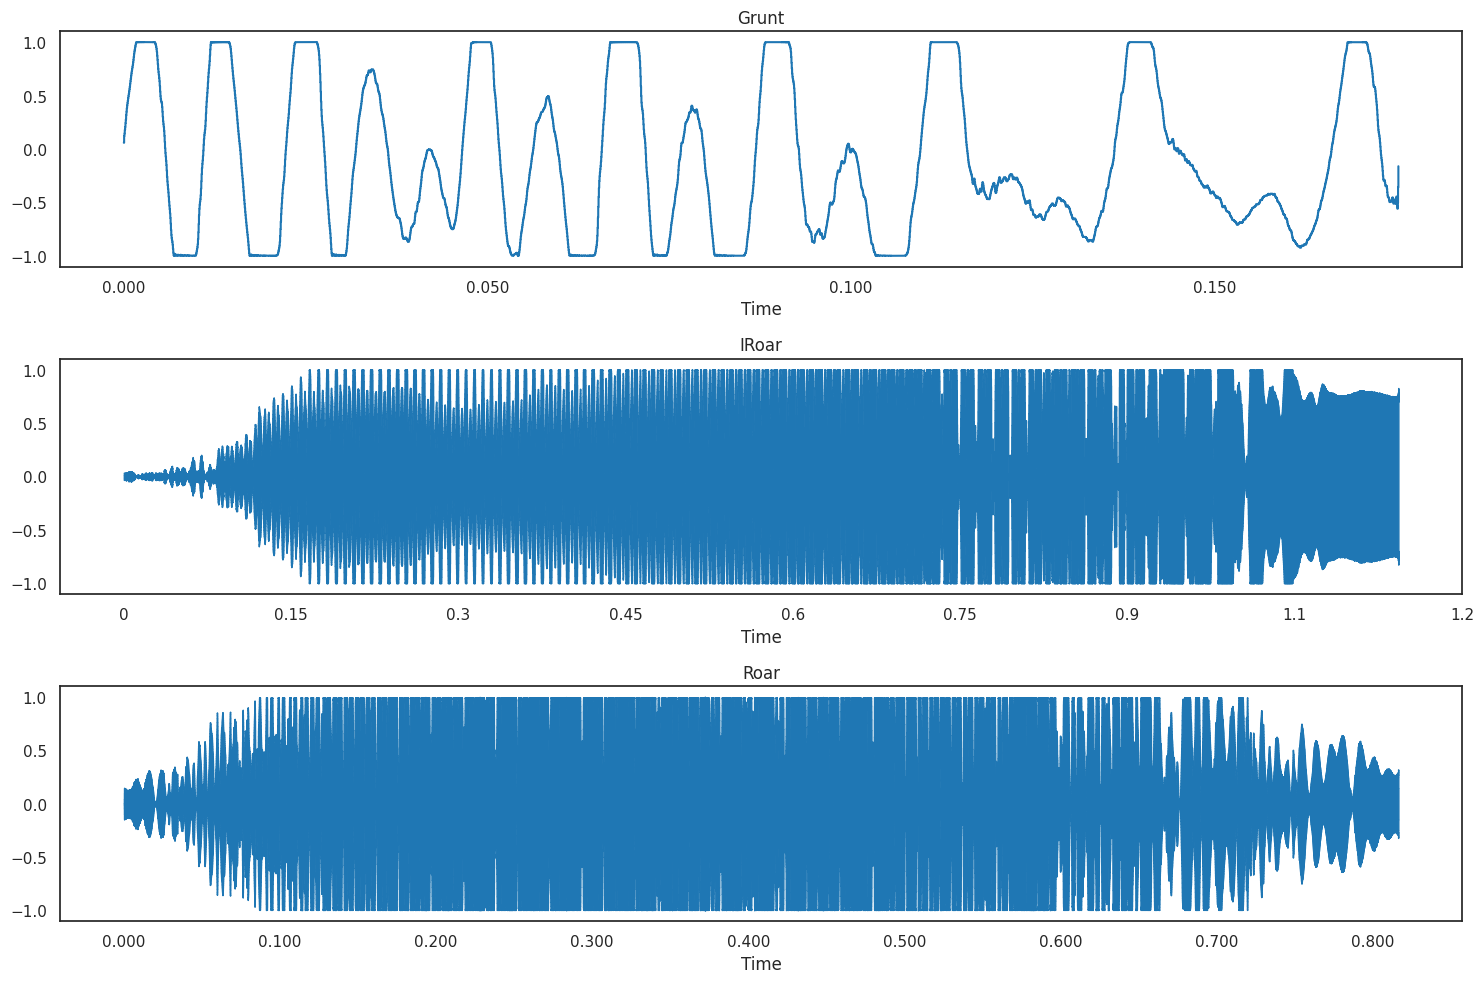

In [12]:
# Randomly select one sample of each class
random_samples = sorted_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

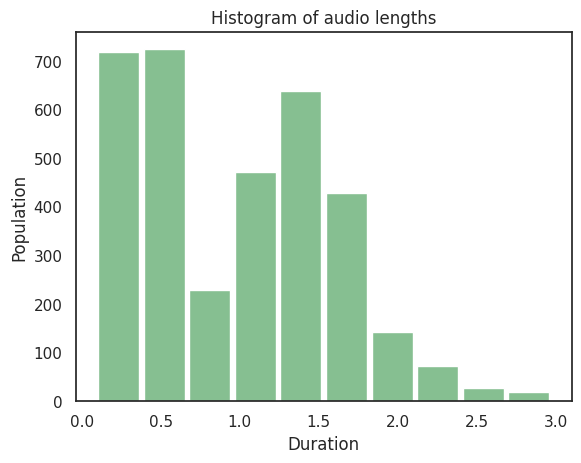

Greater than 3 seconds: 0
Lower than 3 but greater than 2 seconds: 152
Lower than 2 but greater than 1 seconds: 1601
Lower than 1 seconds: 1718


In [13]:
plt.hist(sorted_df['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = sorted_df['duration'][(sorted_df['duration'] > 3)].count()
gt_2sec = sorted_df['duration'][(sorted_df['duration'] > 2) & (sorted_df['duration'] < 3)].count()
lt_2sec = sorted_df['duration'][(sorted_df['duration'] > 1) & (sorted_df['duration'] < 2)].count()
lt_1sec = sorted_df['duration'][sorted_df['duration'] < 1].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 but greater than 2 seconds: {}".format(gt_2sec))
print("Lower than 2 but greater than 1 seconds: {}".format(lt_2sec))
print("Lower than 1 seconds: {}".format(lt_1sec))

In [147]:
# Feature extraction using librosa

data = []
labels = []

start = 0
end = 0

path='/content/drive/MyDrive/ThesisData/File'
for i in tqdm(range(len(sorted_df))):
    fold_no=str(sorted_df.iloc[i]["fold"])
    file=sorted_df.iloc[i]["slice_file_name"]
    label=sorted_df.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename, res_type='kaiser_fast')
    #trim the audio file
    y_trimmed, _ = librosa.effects.trim(y)
    if sorted_df.iloc[i]["class"] == "IRoar":
      start = 22000
      end= 26000
    elif sorted_df.iloc[i]["class"] == "Roar":
      start = 7000
      end= 11000
    elif sorted_df.iloc[i]["class"] == "Grunt":
      start = 2000
      end= 6000
    mfccs = np.mean(librosa.feature.mfcc(y=y_trimmed[start:end], sr=sr, n_mfcc=40).T,axis=0)

    data.append(mfccs)
    labels.append(label)

  0%|          | 8/3471 [00:00<02:28, 23.27it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1208
  warnings.warn(
  1%|          | 26/3471 [00:01<02:49, 20.30it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=784
  warnings.warn(
  1%|▏         | 51/3471 [00:03<04:18, 13.23it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1981
  warnings.warn(
  2%|▏         | 57/3471 [00:03<04:12, 13.52it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
  2%|▏         | 83/3471 [00:05<04:41, 12.04it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=20

In [148]:
data=np.array(data)
labels=np.array(labels)

In [149]:
data.shape, labels.shape

((3471, 40), (3471,))

In [150]:
labels

array([1, 1, 2, ..., 2, 2, 2])

In [151]:
# Shuffle the data
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [152]:
#reshaping to 3D
data=np.reshape(data,(data.shape[0], 1,40))
data.shape

(3471, 1, 40)

In [153]:
#converting to one hot
labels = to_categorical(labels, num_classes=3)
labels = np.reshape(labels, (labels.shape[0], 1,3))
labels.shape

(3471, 1, 3)

In [154]:
# Model
model = Sequential()
model.add(LSTM(40,return_sequences=True,input_shape=(1,40)))
model.add(LSTM(40,input_shape=(1,40),return_sequences=True))
model.add(Dense(512,activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation ='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1, 40)             12960     
                                                                 
 lstm_29 (LSTM)              (None, 1, 40)             12960     
                                                                 
 dense_24 (Dense)            (None, 1, 512)            20992     
                                                                 
 dropout_10 (Dropout)        (None, 1, 512)            0         
                                                                 
 dense_25 (Dense)            (None, 1, 3)              1539      
                                                                 
Total params: 48,451
Trainable params: 48,451
Non-trainable params: 0
_________________________________________________________________


In [155]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [156]:
# Split the data into training and testing sets
split_ratio = 0.6
split_index = int(len(data) * split_ratio)
X_train, X_test = data[:split_index], data[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]

In [157]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2082, 1, 40), (1389, 1, 40), (2082, 1, 3), (1389, 1, 3))

In [158]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

In [159]:
batch_size = 50

In [160]:
# Function to calculate the size of a NumPy array in bytes
def get_size_in_bytes(arr):

    return arr.nbytes

In [161]:
# Training and sequential testing
start_time = time.time()
total_data_read_bytes = 0  # Counter to keep track of data read in bytes across all epochs

for epoch in range(30):  # Adjust the number of epochs as needed
    # Use model.fit to train the model with batch_size and verbose set
    #history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=1, verbose=1)

    # Calculate the number of samples read in this epoch
    num_samples_read_bytes = get_size_in_bytes(X_train)

    total_data_read_bytes += num_samples_read_bytes  # Update the total count

    # Predict probabilities for test set
    predict_x = model.predict(X_test)
    predict_x=np.reshape(predict_x,(predict_x.shape[0],3))
    y_test=np.reshape(y_test,(y_test.shape[0] ,3))

    # Get predicted labels
    y_pred = np.argmax(predict_x, axis=1)
    y_trues = np.argmax(y_test, axis=1)


    # Make predictions on the entire test set
    #predict_x=model.predict(X_test)
    #y_pred=np.argmax(predict_x,axis=1)

    #y_test = np.argmax(y_test, axis=0)

    #print(y_test.shape, y_pred.shape)

    # Calculate accuracy for early classification
    accuracy = accuracy_score(y_trues, y_pred)
    print(f'Epoch {epoch + 1}: Early Accuracy = {accuracy:.2f}, Data Read in Epoch (bytes) = {num_samples_read_bytes}, Total Data Read (bytes) = {total_data_read_bytes}')

    # Check for early stopping based on a predefined accuracy threshold
    if accuracy >= 0.80:  # Adjust the threshold as needed
        break

end_time = time.time()

print(f'Training and Sequential Testing Time: {end_time - start_time:.2f} seconds')

44/44 [==============================] - 1s 5ms/step
Epoch 1: Early Accuracy = 0.74, Data Read in Epoch (bytes) = 333120, Total Data Read (bytes) = 333120
44/44 [==============================] - 0s 4ms/step
Epoch 2: Early Accuracy = 0.79, Data Read in Epoch (bytes) = 333120, Total Data Read (bytes) = 666240
44/44 [==============================] - 0s 4ms/step
Epoch 3: Early Accuracy = 0.80, Data Read in Epoch (bytes) = 333120, Total Data Read (bytes) = 999360
44/44 [==============================] - 0s 4ms/step
Epoch 4: Early Accuracy = 0.81, Data Read in Epoch (bytes) = 333120, Total Data Read (bytes) = 1332480
Training and Sequential Testing Time: 10.21 seconds


In [162]:
#train and test loss and scores respectively
train_loss_score=model.evaluate(X_train,y_train)
test_loss_score=model.evaluate(X_test,y_test)
print(train_loss_score)
print(test_loss_score)

44/44 [==============================] - 2s 5ms/step - loss: 1.9339 - accuracy: 0.3754
[0.47488725185394287, 0.8256484270095825]
[1.9339027404785156, 0.37539875507354736]
